In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
def load_images_labels(base_dir, img_size):
    images = []
    labels = []
    for label_name, folder in enumerate(["Negative_images", "Positive_images"]): 
        folder_path = os.path.join(base_dir, folder)
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR) 
            if img is not None:
                img = cv2.resize(img, (img_size, img_size))
                images.append(img)
                labels.append(label_name) 
    return np.array(images), np.array(labels)


In [ ]:
train_dir = "/Users/vivekreddypalsani/Desktop/train" 
IMG_SIZE = 300
X, y = load_images_labels(train_dir, IMG_SIZE)
X = X / 255.0
y_onehot = np.eye(2)[y]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.25, random_state=42)
y_train_classes = np.argmax(y_train, axis=1) 
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y_train_classes)
class_weights = {i: weight for i, weight in enumerate(class_weights)}
print(f"Class Weights: {class_weights}")

In [ ]:
def create_simplified_cnn(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(2, activation='softmax')) 
    return model

In [ ]:
cnn_model = create_simplified_cnn((IMG_SIZE, IMG_SIZE, 3))  
cnn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2
)
datagen.fit(x_train)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = cnn_model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    validation_data=(x_test, y_test),
    epochs=20,  
    steps_per_epoch=len(x_train) // 32,
    verbose=1,
    callbacks=[early_stopping],  
    class_weight=class_weights 
)

Class Weights: {0: 0.7133501259445844, 1: 1.6717827626918536}


Epoch 1/20


2024-11-26 22:29:33.439462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


88/88 [==============================] - 161s 2s/step - loss: 0.6884 - accuracy: 0.6121 - val_loss: 0.4932 - val_accuracy: 0.8138
Epoch 2/20
88/88 [==============================] - 140s 2s/step - loss: 0.5799 - accuracy: 0.7200 - val_loss: 0.4495 - val_accuracy: 0.8159
Epoch 3/20
88/88 [==============================] - 139s 2s/step - loss: 0.5610 - accuracy: 0.7407 - val_loss: 0.4391 - val_accuracy: 0.8286
Epoch 4/20
88/88 [==============================] - 141s 2s/step - loss: 0.5527 - accuracy: 0.7379 - val_loss: 0.4432 - val_accuracy: 0.8116
Epoch 5/20
88/88 [==============================] - 131s 1s/step - loss: 0.5292 - accuracy: 0.7561 - val_loss: 0.4377 - val_accuracy: 0.8201
Epoch 6/20
88/88 [==============================] - 129s 1s/step - loss: 0.5208 - accuracy: 0.7850 - val_loss: 0.4914 - val_accuracy: 0.7873
Epoch 7/20
88/88 [==============================] - 129s 1s/step - loss: 0.5003 - accuracy: 0.7789 - val_loss: 0.4094 - val_accuracy: 0.8360
Epoch 8/20
88/88 [======

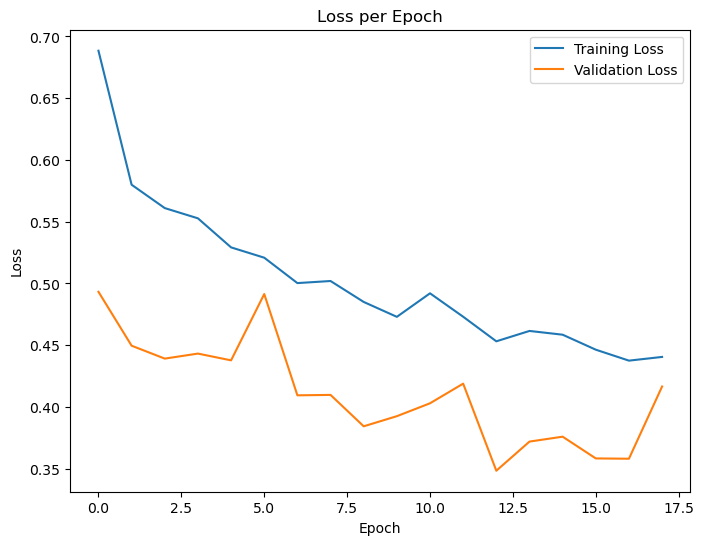

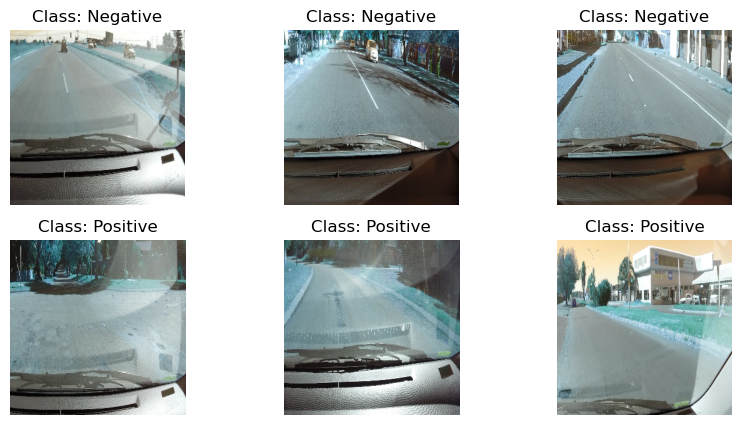

30/30 [==============================] - 12s 310ms/step


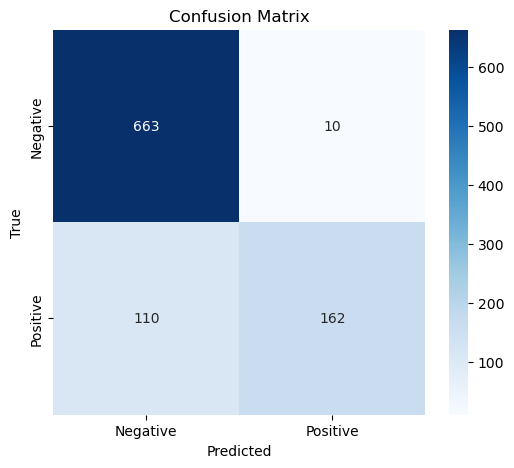

1/1 [==============================] - 0s 39ms/step
Predicted Class: Positive (Confidence: 0.70)


In [ ]:
test_loss, test_acc = cnn_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

def display_samples(images, labels, class_names):
    plt.figure(figsize=(10, 5))
    for class_id in range(2): 
        class_images = images[np.argmax(labels, axis=1) == class_id][:3]  
        for i, img in enumerate(class_images):
            plt.subplot(2, 3, class_id * 3 + i + 1)
            plt.imshow(img)
            plt.title(f"Class: {class_names[class_id]}")
            plt.axis('off')
    plt.show()

class_names = ["Negative", "Positive"]
display_samples(X, y_onehot, class_names)

y_pred = cnn_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

def predict_image(image_path, model, img_size):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is not None:
        img = cv2.resize(img, (img_size, img_size))
        img = img / 255.0  
        img = np.expand_dims(img, axis=0)
        prediction = model.predict(img)
        class_id = np.argmax(prediction)
        confidence = prediction[0][class_id]
        print(f"Predicted Class: {class_names[class_id]} (Confidence: {confidence:.2f})")
    else:
        print("Error: Could not read the image.")

image_path = "/Users/vivekreddypalsani/Desktop/train/Positive_images/G0010033.JPG" 
predict_image(image_path, cnn_model, IMG_SIZE)

In [5]:
cnn_model.save("/Users/vivekreddypalsani/Desktop/dip/new")

INFO:tensorflow:Assets written to: /Users/vivekreddypalsani/Desktop/dip/new/assets


INFO:tensorflow:Assets written to: /Users/vivekreddypalsani/Desktop/dip/new/assets


In [10]:
image_path = "/Users/vivekreddypalsani/Documents/mahindra/mahindra-3rd/3rd-fall/DIP/project/Dataset/test/Test_data/G0011524.JPG"  # Change to a valid image path
predict_image(image_path, cnn_model, IMG_SIZE)

1/1 [==============================] - 0s 76ms/step
Predicted Class: Positive (Confidence: 0.99)


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model(model_save_path)
print("Model loaded successfully.")

# Example usage with the loaded model
predict_image(image_path, loaded_model, IMG_SIZE)